(von_neumann_model)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

```{index} single: python
```

# 冯·诺依曼增长模型（及其推广）

```{contents} 目录
:depth: 2
```

本讲座使用`Neumann`类来计算约翰·冯·诺依曼{cite}`von1937uber`提出的线性增长模型的一些关键要素，该模型后来被Kemeny、Morgenstern和Thompson {cite}`kemeny1956generalization`进行了推广。

我们关注的要素包括最大扩张率（$\alpha$）、利息因子（$β$）、最优强度（$x$）和价格（$p$）。

除了观察约翰·冯·诺依曼这位伟大思想家如何构建均衡增长中的价格和数量向量模型外，本讲还将展示如何有效地运用以下重要工具：

- 零和双人博弈
- 线性规划
- Perron-Frobenius定理

让我们从一些导入开始：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

from scipy.optimize import fsolve, linprog
from textwrap import dedent

np.set_printoptions(precision=2)

以下代码提供了`Neumann`类

In [2]:
class Neumann(object):

    """
    该类描述了Kemeny等人(1956, ECTA)和Gale(1960, 第9.5章)讨论的广义冯·诺依曼增长模型：

    设：
    n ... 商品数量
    m ... 生产活动数量
    A ... 投入矩阵，维度为m×n
        a_{i,j} - 活动i消耗的商品j的数量
    B ... 产出矩阵，维度为m×n
        b_{i,j} - 活动i生产的商品j的数量

    x ... 强度向量(m维向量)，具有非负分量
        x'B - 商品的产出向量
        x'A - 商品的消耗向量
    p ... 价格向量(n维向量)，具有非负分量
        Bp - 每个活动的收入向量
        Ap - 每个活动的成本向量

    A和B的元素都非负。此外，我们假设：
    (1) 假设I(每种被消耗的商品都会被生产)：
        对所有j，b_{.,j} > 0，即至少有一个元素严格为正
    (2) 假设II(没有免费午餐)：
        对所有i，a_{i,.} > 0，即至少有一个元素严格为正

    参数
    ----------
    A : array_like或标量(float)
        状态转移方程的一部分。应为 `m x n` 矩阵
    B : array_like或标量(float)
        状态转移方程的一部分。应为 `m x n` 矩阵
    """

    def __init__(self, A, B):

        self.A, self.B = list(map(self.convert, (A, B)))
        self.m, self.n = self.A.shape

        # 检查(A, B)是否满足基本假设
        assert self.A.shape == self.B.shape, '投入和产出矩阵必须具有相同的维度！'
        assert (self.A >= 0).all() and (self.B >= 0).all(), '投入和产出矩阵必须只包含非负元素！'

        # (1) 检查是否满足假设I：
        if (np.sum(B, 0) <= 0).any():
            self.AI = False
        else:
            self.AI = True

        # (2) 检查是否满足假设II：
        if (np.sum(A, 1) <= 0).any():
            self.AII = False
        else:
            self.AII = True

    def __repr__(self):
        return self.__str__()

    def __str__(self):

        me = """
        广义冯·诺依曼扩张模型：
          - 商品数量              : {n}
          - 生产活动数量          : {m}

        假设：
          - AI:  B的每一列都有正元素    : {AI}
          - AII: A的每一行都有正元素    : {AII}

        """
        # 不可约的                                       : {irr}
        return dedent(me.format(n=self.n, m=self.m,
                                AI=self.AI, AII=self.AII))

    def convert(self, x):
        """
        将类数组对象(列表的列表、浮点数等)转换为规范的2D NumPy数组
        """
        return np.atleast_2d(np.asarray(x))


    def bounds(self):
        """
        计算alpha(扩张率)和beta(利息因子)的简单上下界。
        参见Gale(1960)定理9.8的证明
        """

        n, m = self.n, self.m
        A, B = self.A, self.B

        f = lambda α: ((B - α * A) @ np.ones((n, 1))).max()
        g = lambda β: (np.ones((1, m)) @ (B - β * A)).min()

        UB = fsolve(f, 1).item()  # α, β的上界
        LB = fsolve(g, 2).item()  # α, β的下界

        return LB, UB


    def zerosum(self, γ, dual=False):
        """
        给定gamma，计算由矩阵定义的两人零和博弈的值和最优策略

                M(gamma) = B - gamma * A

        行玩家最大化，列玩家最小化

        零和博弈作为线性规划(原问题 --> α)

            max (0', 1) @ (x', v)
            约束条件
            [-M', ones(n, 1)] @ (x', v)' <= 0
            (x', v) @ (ones(m, 1), 0) = 1
            (x', v) >= (0', -inf)

        零和博弈作为线性规划(对偶问题 --> beta)

            min (0', 1) @ (p', u)
            约束条件
            [M, -ones(m, 1)] @ (p', u)' <= 0
            (p', u) @ (ones(n, 1), 0) = 1
            (p', u) >= (0', -inf)

        输出：
        --------
        value: 标量
            零和博弈的值

        strategy: 向量
            如果dual = False，则为强度向量
            如果dual = True，则为价格向量
        """

        A, B, n, m = self.A, self.B, self.n, self.m
        M = B - γ * A

        if dual == False:
            # 用原始线性规划求解（详情参见上面的描述）
            # (1) 定义待求解问题的目标函数（linprog 默认求最小值，因此这里取负号）
            c = np.hstack([np.zeros(m), -1])

            # (2) 添加约束：
            # ... 非负约束
            bounds = tuple(m * [(0, None)] + [(None, None)])
            # ... 不等式约束
            A_iq = np.hstack([-M.T, np.ones((n, 1))])
            b_iq = np.zeros((n, 1))
            # ... 归一化
            A_eq = np.hstack([np.ones(m), 0]).reshape(1, m + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        else:
            # 用对偶线性规划求解（详情参见上面的描述）
            # (1) 定义待求解问题的目标函数（linprog 默认求最小值，因此这里取负号）
            c = np.hstack([np.zeros(n), 1])

            # (2) 添加约束：
            # ... 非负约束
            bounds = tuple(n * [(0, None)] + [(None, None)])
            # ... 不等式约束
            A_iq = np.hstack([M, -np.ones((m, 1))])
            b_iq = np.zeros((m, 1))
            # ... 归一化
            A_eq = np.hstack([np.ones(n), 0]).reshape(1, n + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        if res.status != 0:
            print(res.message)

        # 提取所需的量
        value = res.x[-1]
        strategy = res.x[:-1]

        return value, strategy


    def expansion(self, tol=1e-8, maxit=1000):
        """
        这里使用的算法来自Hamburger-Thompson-Weil(1967, ECTA)。
        它基于简单的二分法，并利用了这样一个思想：对于给定的γ(= α或β)，
        矩阵"M = B - γ * A"定义了一个两人零和博弈，其中最优策略是
        (归一化的)强度和价格向量。

        输出：
        --------
        alpha: 标量
            最优扩张率
        """

        LB, UB = self.bounds()

        for iter in range(maxit):

            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ)
            V = ZS[0]     # γ对应的博弈值

            if V >= 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                x = self.zerosum(γ=γ)[1]
                p = self.zerosum(γ=γ, dual=True)[1]
                break

        return γ, x, p

    def interest(self, tol=1e-8, maxit=1000):
        """
        这里使用的算法来自Hamburger-Thompson-Weil(1967, ECTA)。
        它基于简单的二分法，并利用了这样一个思想：对于给定的γ(= α或β)，
        矩阵"M = B - γ * A"定义了一个两人零和博弈，其中最优策略是
        (归一化的)强度和价格向量。

        输出：
        --------
        beta: 标量
            最优利率
        """

        LB, UB = self.bounds()

        for iter in range(maxit):
            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=True)
            V = ZS[0]

            if V > 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                p = self.zerosum(γ=γ, dual=True)[1]
                x = self.zerosum(γ=γ)[1]
                break

        return γ, x, p

## 符号表示

我们使用以下符号表示。

$\mathbf{0}$ 表示零向量。

对于一个 $n$ 维向量，如果对所有 $i=1,2,\dots,n$ 都有 $x_i>0$，我们称之为**正向量**，记作 $x\gg \mathbf{0}$。

如果对所有 $i=1,2,\dots,n$ 都有 $x_i\geq 0$，我们称之为**非负向量**，记作 $x\geq \mathbf{0}$。

如果 $x\geq \mathbf{0}$ 且 $x\neq \mathbf{0}$，我们称之为**半正向量**，记作 $x > \mathbf{0}$。

对于两个可比向量 $x$ 和 $y$，$x\gg y$、$x\geq y$ 和 $x> y$ 分别表示 $x-y\gg \mathbf{0}$、$x-y \geq \mathbf{0}$ 和 $x-y > \mathbf{0}$。

本讲中所有向量均为列向量；$x^{T}$ 表示 $x$ 的转置（即行向量）。

用 $\iota_n$ 表示由 $n$ 个1组成的列向量，即 $\iota_n = (1,1,\dots,1)^T$。

用 $e^i$ 表示一个（任意维度的）向量，除第 $i$ 个位置为1外，其余位置均为0。

我们用大写字母表示矩阵。对于任意矩阵 $A$，$a_{i,j}$ 表示其第 $i$ 行、第 $j$ 列的元素。

$a_{\cdot j}$ 和 $a_{i\cdot}$ 分别表示矩阵 $A$ 的第 $j$ 列和第 $i$ 行。

## 模型要素和假设

一对 $m\times n$ 非负矩阵 $(A,B)$ 定义了一个经济体。

- $m$ 是*活动*（或部门）的数量
- $n$ 是*商品*（生产和/或消费）的数量
- $A$ 被称为*投入矩阵*；$a_{i,j}$ 表示活动 $i$ 消耗的商品 $j$ 的数量
- $B$ 被称为*产出矩阵*；$b_{i,j}$ 表示活动 $i$ 生产的商品 $j$ 的数量

两个关键假设限制经济 $(A,B)$：

````{prf:assumption} 每种被消费的商品也都被生产。
:label: assumption1

```{math}
  b_{.,j} > \mathbf{0}\hspace{5mm}\forall j=1,2,\dots,n
```
````

````{prf:assumption} 没有免费午餐
:label: assumption2
```{math}
  a_{i,.} > \mathbf{0}\hspace{5mm}\forall i=1,2,\dots,m
```
````

半正*强度* $m$ 维向量 $x$ 表示活动的运行水平。

因此，

- 向量 $x^TA$ 表示*生产中使用的商品总量*
- 向量 $x^TB$ 表示*总产出*

如果存在一个非负强度向量 $x \geq 0$ 使得 $x^T B > x^TA$，则称经济体 $(A,B)$ 是*生产性的*。

半正 $n$ 维向量 $p$ 包含了分配给 $n$ 种商品的价格。

向量 $p$ 决定了*成本*和*收入*向量

- 向量 $Ap$ 表示各项活动的*成本*
- 向量 $Bp$ 表示各项活动的*收入*

投入-产出对 $(A,B)$ 的一个性质被称为**不可约性**（或不可分解性），它决定了一个经济系统能否被分解为多个“子经济体”。

```{prf:definition}
对于经济体 $(A,B)$，如果存在商品的一个子集 $S \subset \{1,2,\dots,n\}$，在不消耗集合 $S$ 以外商品的情况下就可以生产 $S$ 中的每种商品，那么称 $S$ 是一个*独立子集*。

形式上，如果集合 $S$ 满足以下条件，则称其为独立的：$\exists T\subset \{1,2,\dots,m\}$（活动的一个子集），使得对于所有 $i\in T$ 和 $j\in S^c$，有 $a_{i,j}=0$，且对于所有 $j\in S$，$\exists i\in T$ 使得 $b_{i,j}>0$。

如果不存在真独立子集，则称该经济是**不可约的**。
```

我们研究两个例子，都来自Gale的著作第9.6章 {cite}`gale1989theory`

In [3]:
# (1) 不可约的(A, B)例子：α_0 = β_0
A1 = np.array([[0, 1, 0, 0],
               [1, 0, 0, 1],
               [0, 0, 1, 0]])

B1 = np.array([[1, 0, 0, 0],
               [0, 0, 2, 0],
               [0, 1, 0, 1]])

# (2) 可约的(A, B)例子：β_0 < α_0
A2 = np.array([[0, 1, 0, 0, 0, 0],
               [1, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, 0, 0],
               [0, 0, 1, 0, 0, 1],
               [0, 0, 0, 0, 1, 0]])

B2 = np.array([[1, 0, 0, 1, 0, 0],
               [0, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 0, 2, 0],
               [0, 0, 0, 1, 0, 1]])

下面的代码设置了我们的第一个诺伊曼经济的实例

In [4]:
n1 = Neumann(A1, B1)
n1


广义冯·诺依曼扩张模型：
  - 商品数量              : 4
  - 生产活动数量          : 3

假设：
  - AI:  B的每一列都有正元素    : True
  - AII: A的每一行都有正元素    : True


这是第二个诺伊曼经济的实例

In [5]:
n2 = Neumann(A2, B2)
n2


广义冯·诺依曼扩张模型：
  - 商品数量              : 6
  - 生产活动数量          : 5

假设：
  - AI:  B的每一列都有正元素    : True
  - AII: A的每一行都有正元素    : True


## 动态解释

现在给上述模型的所有对象附加一个时间指标 $t$，将经济体视为一个动态系统，并考虑以下序列：

$$
\{(A_t,B_t)\}_{t\geq 0}, \hspace{1cm}\{x_t\}_{t\geq 0},\hspace{1cm} \{p_t\}_{t\geq 0}
$$

一个有趣的特殊情况是保持技术过程不变，仅研究商品数量和价格的动态变化。

因此，在本讲座的剩余部分，我们假设对所有 $t\geq 0$ 都有 $(A_t,B_t)=(A,B)$。

动态解释中一个关键因素是生产的时间安排。

我们假设生产（投入品的消耗）发生在 $t$ 期，而相应的产出在 $t+1$ 期实现，即在 $t$ 期消耗 $x_{t}^TA$ 将在 $t+1$ 期产生 $x^T_{t}B$ 数量的产出。

这一时序约定意味着以下可行性条件：

$$
\begin{aligned}
x^T_{t}B \geq x^T_{t+1} A \hspace{1cm}\forall t\geq 1
\end{aligned}
$$

这表明今天消耗的商品不能超过昨天生产的数量。

因此，$Ap_t$ 表示第 $t$ 期的生产成本，而 $Bp_t$ 表示第 $t+1$ 期的收入。

### 平衡增长

我们按照约翰·冯·诺依曼的方法来研究“平衡增长”。

让 $./$表示两个向量的逐元素除法，让 $\alpha >0$ 为一个标量。

那么**平衡增长**指的是如下情形：

$$
x_{t+1}./x_t = \alpha , \quad \forall t \geq 0
$$

在平衡增长下，$x$ 的运动规律显然是 $x_{t+1}=\alpha x_t$，因此我们可以将可行性约束重写为：

$$
x^T_{t}B \geq \alpha x^T_t A \hspace{1cm}\forall t
$$

类似地，将 $\beta\in\mathbb{R}$ 定义为每单位时间的**利息因子**。

我们假设，通过在“模型外”投资始终可以获得等于常数利息因子 $\beta$ 的总回报。

基于该假设，一个无套利条件对价格序列提出了如下的（无利润）限制：

$$
\beta Ap_{t} \geq B p_{t} \hspace{1cm}\forall t
$$

这表明生产的回报不能超过外部投资机会所提供的回报（这里我们比较第$t+1$期的价值）。

平衡增长假设使我们可以省略时间下标，并完全基于时不变的增长率 $\alpha$ 和利息因子 $\beta$ 进行分析。

## 对偶性

经济系统的技术特征和价值特征之间存在一个值得注意的的对偶关系，将下面两个问题联系在一起：

```{prf:definition}
经济体 $(A,B)$ 的**技术扩张问题**（technological expansion problem, TEP）是找到一个半正 $m$ 维向量 $x>0$ 和一个实数 $\alpha\in\mathbb{R}$，使其满足

$$
\begin{aligned}
    &\max_{\alpha} \hspace{2mm} \alpha\\
    \text{使得 }\hspace{2mm} & x^\top B \geq \alpha x^\top A
    \end{aligned}
$$
```

David Gale的著作中的定理9.3 {cite}`gale1989theory`指出，如果假设I和II都满足，那么$\alpha$的最大值存在且为正数。

这个最大值被称为*技术扩张率*，用$\alpha_0$表示。相应的强度向量$x_0$被称为*最优强度向量*。

```{prf:definition}
$(A,B)$ 的经济扩张问题（economic expansion problem, EEP）是要找到一个半正 $n$ 维向量 $p>0$ 和一个实数 $\beta\in\mathbb{R}$，使其满足

$$
\begin{aligned}
    &\min_{\beta} \hspace{2mm} \beta\\
    \text{使得 }\hspace{2mm} & Bp \leq \beta Ap
\end{aligned}
$$
```

{prf:ref}`assumption1` 和 {prf:ref}`assumption2`意味着存在一个最小值 $\beta_0>0$，称为*经济扩张率*。

相应的价格向量$p_0$是*最优价格向量*。

由于*技术扩张*问题和*经济扩张问题*中的目标函数都是线性齐次的，$x_0$ 和 $p_0$ 的最优性仅由一个正的比例因子来定义。

为了方便（并强调与零和博弈的密切联系），我们将向量 $x_0$ 和 $p_0$ 都归一化为单位长度。

标准对偶性论证（参见 (Gale, 1960) {cite}`gale1989theory` 中的引理9.4）表明，在{prf:ref}`assumption1` 和 {prf:ref}`assumption2`下，$\beta_0\leq \alpha_0$。

但要推导出 $\beta_0\geq \alpha_0$，{prf:ref}`assumption1` 和 {prf:ref}`assumption2`是不够的。

因此，冯·诺依曼 {cite}`von1937uber` 继续证明了以下连接TEP和EEP的重要“对偶性”结果。

```{prf:theorem} 冯·诺依曼
:label: theorem1

如果经济体 $(A,B)$ 满足{prf:ref}`assumption1` 和 {prf:ref}`assumption2`，则存在 $\left(\gamma^{*}, x_0, p_0\right)$，其中 $\gamma^{*}\in[\beta_0, \alpha_0]\subset\mathbb{R}$，$x_0>0$ 是一个 $m$ 维向量，$p_0>0$ 是一个 $n$ 维向量，且以下套利关系成立

$$
\begin{aligned}
x_0^\top B &\geq \gamma^{* } x_0^\top A \\
Bp_0 &\leq \gamma^{* } Ap_0 \\
x_0^\top \left(B-\gamma^{* } A\right)p_0 &= 0
\end{aligned}
$$
```

```{prf:proof} （概要）
{prf:ref}`assumption1` 和 {prf:ref}`assumption2`意味着存在 $(\alpha_0, x_0)$ 和 $(\beta_0, p_0)$ 分别解决TEP和EEP。

如果 $\gamma^*>\alpha_0$，根据 $\alpha_0$ 的定义，不可能存在半正向量 $x$ 满足$x^T B \geq \gamma^{* } x^T A$。

类似地，如果 $\gamma^*<\beta_0$，不存在半正向量 $p$ 满足 $Bp \leq \gamma^{* } Ap$。令 $\gamma^{* }\in[\beta_0, \alpha_0]$，则 $x_0^T B \geq \alpha_0 x_0^T A \geq \gamma^{* } x_0^T A$。

此外，$Bp_0\leq \beta_0 A p_0\leq \gamma^* A p_0$。这两个不等式意味着$x_0\left(B - \gamma^{* } A\right)p_0 = 0$。
```

这里常数$\gamma^{*}$既是扩张因子也是利息因子（但不一定是最优的）。

我们已经遇到并讨论了前两个不等式，它们分别表示可行性条件和无利润条件。

此外，等式$x_0^T\left(B-\gamma^{* } A\right)p_0 = 0$简洁地表达了以下要求：如果任何商品的增长率大于$\gamma^{*}$（即*供过于求*），那么其价格必须为零；如果任何生产活动带来负利润，则该活动必须停止。

因此，{prf:ref}`theorem1`中所述的条件包含了所有均衡条件。

所以{prf:ref}`theorem1`本质上表明，在{prf:ref}`assumption1` 和 {prf:ref}`assumption2`下，总是存在具有平衡增长的均衡 $\left(\gamma^{*}, x_0, p_0\right)$。

注意，{prf:ref}`theorem1`并未说明均衡的唯一性。事实上，它并不排除 $x_0^TBp_0 = 0$ 的（平凡）情况，即没有产生任何有价值的产出。

为了排除这种无趣的情况，Kemeny、Morgenstern和Thompson {cite}`kemeny1956generalization`增加了一个额外要求

$$
x^T_0 B p_0 > 0
$$

并将满足该条件的均衡称为*经济解*。

他们证明，这个额外条件不影响均衡的存在性，同时显著减少了（相关的）解的数量。

## 作为零和双人博弈的解释

为了计算均衡 $(\gamma^{*}, x_0, p_0)$，我们遵循 Hamburger、Thompson 和 Weil (1967) 提出的算法，基于这样一个关键洞察：（伴随平衡增长的）均衡可以看作是一个特殊的双人零和博弈的解。

首先，我们引入一些符号。

考虑 $m\times n$ 矩阵 $C$ 作为支付矩阵，其中的元素表示从列玩家（**最小化**方）向行玩家（**最大化**方）支付的收益，并假设玩家可以使用混合策略。因此，

* 行玩家选择 $m$ 维向量 $x > \mathbf{0}$，满足 $\iota_m^T x = 1$
* 列玩家选择 $n$ 维向量 $p > \mathbf{0}$，满足 $\iota_n^T p = 1$

```{prf:definition}
$m\times n$ 矩阵博弈 $C$ 在混合策略中有*解* $(x^*, p^*, V(C))$，如果

$$
\begin{aligned}
(x^* )^\top C e^j \geq V(C)\quad \forall j\in\{1, \dots, n\}\quad \quad
\text{and}\quad\quad (e^i)^\top C p^* \leq V(C)\quad \forall i\in\{1, \dots, m\}
\end{aligned}
$$

数值 $V(C)$ 被称为博弈的*值*。
```

从上述定义可以清楚地看出，值 $V(C)$ 有两种解释：

* 通过采用适当的混合策略，最大化玩家可以确保至少获得 $V(C)$（无论列玩家如何选择）

* 通过采用适当的混合策略，最小化玩家可以确保最大化玩家获得的不会超过 $V(C)$（无论最大化玩家如何选择）

Nash (1951) 的一个著名定理告诉我们，任何*有限*的双人零和博弈总是存在混合策略纳什均衡。

此外，冯·诺依曼的最小最大值定理 {cite}`neumann1928theorie` 表明

$$
V(C) = \max_x \min_p \hspace{2mm} x^T C p = \min_p \max_x \hspace{2mm} x^T C p = (x^*)^T C p^*
$$

### 与线性规划(LP)的联系

有限双人零和博弈的纳什均衡可以通过解一个线性规划问题得到。

为了说明这一点，我们引入以下符号

* 对于固定的 $x$，令 $v$ 为最小化问题的值：$v \equiv \min_p x^T C p = \min_j x^T C e^j$
* 对于固定的 $p$，令 $u$ 为最大化问题的值：$u \equiv \max_x x^T C p = \max_i (e^i)^T C p$

那么，从最大化玩家角度来看的*最大最小问题*可以写成*原始*线性规划问题

$$
\begin{aligned}
V(C) = & \max \hspace{2mm} v \\
\text{使得 } \hspace{2mm} v \iota_n^T &\leq x^T C  \\
x &\geq \mathbf{0} \\
\iota_n^T x & = 1
\end{aligned}
$$

而从最小化玩家角度来看的*最小最大问题*是*对偶*线性规划问题

$$
\begin{aligned}
V(C) = &\min \hspace{2mm} u \\
\text{使得 } \hspace{2mm}u \iota_m &\geq Cp  \\
p &\geq \mathbf{0} \\
\iota_m^T p & = 1
\end{aligned}
$$

Hamburger、Thompson和Weil {cite}`hamburger1967computation` 将经济的投入产出对视为双人零和博弈的收益矩阵。

使用这种解释，他们将{prf:ref}`assumption1` 和 {prf:ref}`assumption2`重述如下

$$
V(-A) < 0\quad\quad \text{和}\quad\quad V(B)>0
$$

```{prf:proof} （概要）
* $\Rightarrow$ $V(B)>0$ 意味着$x_0^T B \gg \mathbf{0}$，其中 $x_0$ 是最大化向量。由于 $B$ 是非负的，这要求 $B$ 的每一列至少有一个正项，这就是假设I。
* $\Leftarrow$ 从假设I和事实 $p>\mathbf{0}$ 可知，$Bp > \mathbf{0}$。这意味着最大化玩家总能选择 $x$
使得 $x^TBp>0$，因此必然有$V(B)>0$。
```

为了用特定的双人零和博弈重述{prf:ref}`theorem1`，我们定义一个矩阵，对于 $\gamma\in\mathbb{R}$

$$
M(\gamma) \equiv B - \gamma A
$$

对于固定的 $\gamma$，将 $M(\gamma)$ 视为一个矩阵博弈，

计算博弈的解意味着

- 如果 $\gamma > \alpha_0$，那么对于所有 $x>0$，存在 $j\in\{1, \dots, n\}$，使得 $[x^T M(\gamma)]_j < 0$，这意味着 $V(M(\gamma)) < 0$。
- 如果 $\gamma < \beta_0$，那么对于所有 $p>0$，存在 $i\in\{1, \dots, m\}$，使得 $[M(\gamma)p]_i > 0$，这意味着 $V(M(\gamma)) > 0$。
- 如果 $\gamma \in \{\beta_0, \alpha_0\}$，那么（根据{prf:ref}`theorem1`）最优强度和价格向量 $x_0$ 和 $p_0$ 满足
$$
x_0^T M(\gamma) \geq \mathbf{0}^T \quad \quad \text{和}\quad\quad M(\gamma) p_0 \leq \mathbf{0}
$$

也就是说，$(x_0, p_0, 0)$ 是博弈 $M(\gamma)$ 的解，因此 $V\left(M(\beta_0)\right) = V\left(M(\alpha_0)\right) = 0$。

* 如果 $\beta_0 < \alpha_0$ 且 $\gamma \in (\beta_0, \alpha_0)$，那么 $V(M(\gamma)) = 0$。

此外，如果 $x'$ 是在 $\gamma'\in(\beta_0, \alpha_0)$ 时博弈 $M(\gamma')$ 中最大化玩家的最优策略且 $p''$ 对于 $M(\gamma'')$ 中的最小化玩家来说是最优的，其中 $\gamma''\in(\beta_0, \gamma')$，那么 $(x', p'', 0)$ 对于所有 $\gamma\in (\gamma'', \gamma')$ 都是 $M(\gamma)$ 的解。

```{prf:proof} （概要）
如果 $x'$ 对于游戏 $M(\gamma')$ 中的最大化玩家是最优的，那么 $(x')^T M(\gamma')\geq \mathbf{0}^T$，因此对于所有 $\gamma<\gamma'$，

$$
(x')^T M(\gamma) = (x')^T M(\gamma') + (x')^T(\gamma' - \gamma)A \geq \mathbf{0}^T
$$

因此 $V(M(\gamma))\geq 0$。如果 $p''$ 对于游戏 $M(\gamma'')$ 中的最小化玩家是最优的，那么 $M(\gamma)p \leq \mathbf{0}$，因此对于所有 $\gamma''<\gamma$：

$$
M(\gamma)p'' = M(\gamma'') + (\gamma'' - \gamma)Ap'' \leq \mathbf{0}
$$

因此 $V(M(\gamma))\leq 0$。
```

从上述论证中可以清楚地看出，$\beta_0$、$\alpha_0$ 是使得 $V(M(\gamma))=0$ 的最小和最大的 $\gamma$ 值。

此外，Hamburger等人{cite}`hamburger1967computation`证明了函数 $\gamma \mapsto V(M(\gamma))$ 是连续的且关于 $\gamma$ 单调递减的。

这启发了一种算法来计算给定投入-产出对 $(A, B)$ 的 $(\alpha_0, x_0)$ 和 $(\beta_0, p_0)$。

### 算法

Hamburger、Thompson和Weil {cite}`hamburger1967computation`提出了一个简单的二分算法来找到函数 $\gamma \mapsto V(M(\gamma))$ 的最小和最大根（即$\beta_0$和$\alpha_0$）。

#### 第1步

首先，注意到我们可以很容易地为 $\alpha_0$ 和 $\beta_0$ 找到平凡的上下界。

* TEP要求 $x^T(B-\alpha A)\geq \mathbf{0}^T$ 且 $x > \mathbf{0}$，所以如果 $\alpha$ 大到使得 $\max_i\{[(B-\alpha A)\iota_n]_i\} < 0$，那么TEP将不再有解。

相应地，令 **``UB``** 为满足 $\max_i\{[(B-\alpha^{*} A)\iota_n]_i\} = 0$ 的 $\alpha^{*}$。

* 类似于上界，如果 $\beta$ 低到使得 $\min_j\{[\iota^T_m(B-\beta A)]_j\}>0$，那么EEP将没有解。因此我们可以定义 **``LB``** 为满足 $\min_j\{[\iota^T_m(B-\beta^{*} A)]_j\}=0$ 的 $\beta^{*}$。

*bounds* 方法为我们计算了这些平凡的上下界。

In [6]:
n1.bounds()

(1.0, 2.0)

#### 第2步

计算 $\alpha_0$ 和 $\beta_0$

- 求解 $\alpha_0$
    1. 固定 $\gamma = \frac{UB + LB}{2}$ 并计算与 $M(\gamma)$ 
       相关的双人零和博弈的解。我们可以使用原始或对偶线性规划问题。
    1. 如果 $V(M(\gamma)) \geq 0$，则令 $LB = \gamma$，
       否则令 $UB = \gamma$。
    1. 重复步骤1和2，直到 $|UB - LB| < \epsilon$。
- 求解 $\beta_0$
    1. 固定 $\gamma = \frac{UB + LB}{2}$ 并计算与 $M(\gamma)$ 
       相关的双人零和博弈的解。我们可以使用原始或对偶
       线性规划问题。
    1. 如果 $V(M(\gamma)) > 0$，则令 $LB = \gamma$，
       否则令 $UB = \gamma$。
    1. 重复步骤1和2，直到 $|UB - LB| < \epsilon$。
- *存在性*：由于 $V(M(LB))>0$ 且 $V(M(UB))<0$，并且
  $V(M(\cdot))$ 是连续的非增函数，因此在
  $[LB, UB]$ 区间内至少存在一个 $\gamma$，使得 $V(M(\gamma))=0$。

*zerosum*方法会计算给定 $\gamma$ 时的博弈值和最优策略。

In [7]:
γ = 2

print(f'博弈在 γ = {γ} 时的值')
print(n1.zerosum(γ=γ)[0])
print('强度向量（来自原问题）')
print(n1.zerosum(γ=γ)[1])
print('价格向量（来自对偶问题）')
print(n1.zerosum(γ=γ, dual=True)[1])

博弈在 γ = 2 时的值
-0.24
强度向量（来自原问题）
[0.32 0.28 0.4 ]
价格向量（来自对偶问题）
[0.4  0.32 0.28 0.  ]


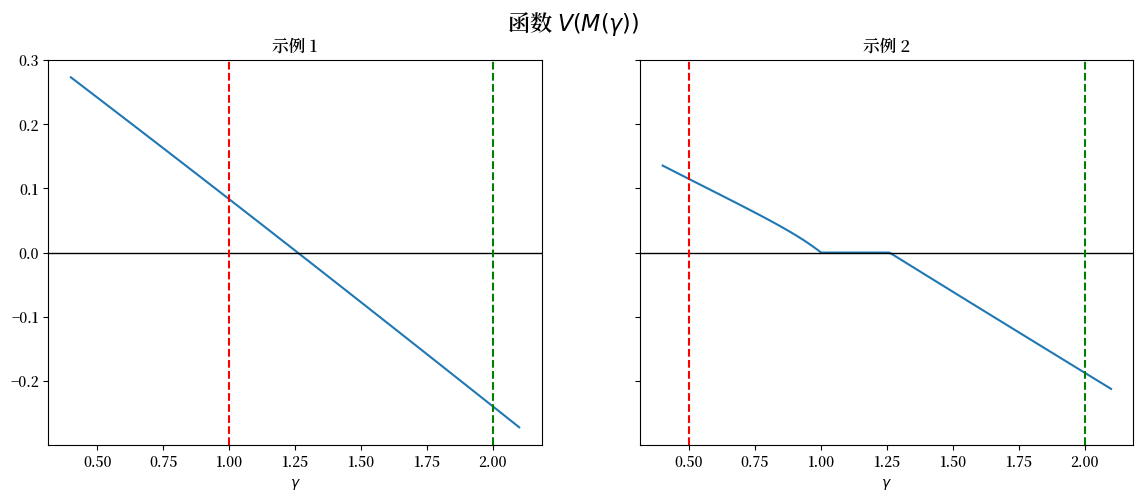

In [8]:
numb_grid = 100
γ_grid = np.linspace(0.4, 2.1, numb_grid)

value_ex1_grid = np.asarray([n1.zerosum(γ=γ_grid[i])[0]
                            for i in range(numb_grid)])
value_ex2_grid = np.asarray([n2.zerosum(γ=γ_grid[i])[0]
                            for i in range(numb_grid)])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.suptitle(r'函数 $V(M(\gamma))$', fontsize=16)

for ax, grid, N, i in zip(axes, (value_ex1_grid, value_ex2_grid),
                          (n1, n2), (1, 2)):
    ax.plot(γ_grid, grid)
    ax.set(title=f'示例 {i}', xlabel=r'$\gamma$')
    ax.axhline(0, c='k', lw=1)
    ax.axvline(N.bounds()[0], c='r', ls='--', label='下界')
    ax.axvline(N.bounds()[1], c='g', ls='--', label='上界')

plt.show()

*expansion*方法使用二分算法求解 $\alpha_0$（并使用原始线性规划问题求解 $x_0$）

In [9]:
α_0, x, p = n1.expansion()
print(f'α_0 = {α_0}')
print(f'x_0 = {x}')
print(f'对偶问题得到的相应p值 = {p}')

α_0 = 1.2599210478365421
x_0 = [0.33 0.26 0.41]
对偶问题得到的相应p值 = [0.41 0.33 0.26 0.  ]


*interest* 方法使用二分算法求解 $\beta_0$ (并使用对偶线性规划问题求解 $p_0$)

In [10]:
β_0, x, p = n1.interest()
print(f'β_0 = {β_0}')
print(f'p_0 = {p}')
print(f'The corresponding x from the primal = {x}')

β_0 = 1.2599210478365421
p_0 = [0.41 0.33 0.26 0.  ]
The corresponding x from the primal = [0.33 0.26 0.41]


当然，当 $\gamma^*$ 唯一时，我们使用哪种方法都无所谓 —— 两种方法都可行。

特别是，如下所示，在 $(A,B)$ 不可约的情况下（如例1），$V(M(\gamma))$ 的最大根和最小根必然相同，这意味着一个“完全对偶”的结果 ，即 $\alpha_0 = \beta_0 = \gamma^*$，因此扩张（和利息）率 $\gamma^*$ 是唯一的。

### 唯一性和不可约性

作为说明，让我们首先计算例2中可约投入-产出对 $(A, B)$ 的 $V(M(\cdot))$ 的最大根和最小根

In [11]:
α_0, x, p = n2.expansion()
print(f'α_0 = {α_0}')
print(f'x_0 = {x}')
print(f'The corresponding p from the dual = {p}')

α_0 = 1.259921052493155
x_0 = [5.27e-10 0.00e+00 3.27e-01 2.60e-01 4.13e-01]
The corresponding p from the dual = [0.   0.21 0.33 0.26 0.21 0.  ]


In [12]:
β_0, x, p = n2.interest()
print(f'β_0 = {β_0}')
print(f'p_0 = {p}')
print(f'对偶问题得到的原问题解为 = {x}')

β_0 = 1.0000000009313226
p_0 = [ 5.00e-01  5.00e-01 -1.55e-09 -1.24e-09 -9.31e-10  0.00e+00]
对偶问题得到的原问题解为 = [-0.    0.    0.25  0.25  0.5 ]


如我们所见，当$(A,B)$可约时，二分法算法找到的根可能不同，因此可能存在多个使得博弈$M(\gamma^*)$的值为零的 $\gamma^*$（见上图）。

事实上，虽然冯·诺依曼定理保证了均衡的存在性，但假设I和II并不足以保证唯一性。尽管如此，Kemeny等人(1967)证明了经济解的数量至多是有限的，这意味着只有有限个 $\gamma^*$ 满足 $V(M(\gamma^*)) = 0$ 和 $x_0^TBp_0 > 0$，并且对于每个这样的 $\gamma^*_i$，都存在一个经济体的自包含部分（子经济体），在均衡状态下可以以扩张系数 $\gamma^*_i$ 独立扩张。

以下定理（参见Gale {cite}`gale1989theory`中的定理9.10）断言，施加不可约性条件足以保证 $(\gamma^*, x_0, p_0)$ 的唯一性。

```{prf:theorem}
:label: theorem2

采用{prf:ref}`theorem1`的条件。如果经济体 $(A,B)$ 不可约，则 $\gamma^*=\alpha_0=\beta_0$。
```

### 特殊情况

有一种特殊的 $(A,B)$ 允许我们通过引用非负矩阵的 Perron-Frobenius 定理来显著简化求解方法。

```{prf:definition}
如果一个经济体满足以下条件，我们称之为*简单*的：

* $n=m$
* 每个生产活动恰好生产一种商品
* 每种商品恰好由一个生产活动生产
```

这些假设意味着 $B=I_n$，即 $B$ 可以写成单位矩阵（可能需要重新排列其行和列）。

简单模型具有以下特殊性质（参见Gale {cite}`gale1989theory` 中的定理 9.11）：如果 $x_0$ 和 $\alpha_0>0$ 是 $(A,I_n)$ 的 TEP 的解，那么

$$
x_0^T = \alpha_0 x_0^T A\hspace{1cm}\Leftrightarrow\hspace{1cm}x_0^T
A=\left(\frac{1}{\alpha_0}\right)x_0^T
$$

后者表明 $1/\alpha_0$ 是 $A$ 的一个正特征值，而 $x_0$ 是相应的非负左特征向量。

**Perron和Frobenius**的经典结果表明：任意非负矩阵都存在一个非负的特征值–特征向量对。

此外，如果 $A$ 是不可约的，则最优强度向量 $x_0$ 是正的，并且除了一个正的比例因子之外是唯一的。

假设 $A$ 是可约的，具有 $k$ 个不可约子集 $S_1,\dots,S_k$。令 $A_i$ 为对应于 $S_i$ 的子矩阵，令 $\alpha_i$ 和 $\beta_i$ 分别为相关的扩张因子和利息因子，那么我们有

$$
\alpha_0 = \max_i \{\alpha_i\}\hspace{1cm}\text{和}\hspace{1cm}\beta_0 = \min_i \{\beta_i\}
$$